Sistema baseado na rede de distribuição de gás natural

1 Duto

equações :
$$
\frac{\partial}{\partial t}
\begin{bmatrix}
T \\
V \\
w
\end{bmatrix}
=
\begin{bmatrix}
-w & 0 & -T \frac{V^{*} P'_T}{C_V} \\
0 & -w & V \\
- V^{*} P'_T & -V^{*} P'_V & -w
\end{bmatrix}
\frac{\partial}{\partial x}
\begin{bmatrix}
T \\
V \\
w
\end{bmatrix}
+
\begin{bmatrix}
\frac{f w^2 |w|}{2 D C_V} + \frac{q}{C_V} \\
0 \\
\frac{f w |w|}{2 D}
\end{bmatrix}
$$
Retirado da Tese de doutorado em Engenharia Industrial de Rodrigo Lima Meira.

| **Variável**      | **Valor**           | **Unidade**     |
|-------------------|---------------------|-----------------|
| 𝜀                 | 1,5 × 10⁻⁶          | m               |
| κₛₒₗₒ             | 0,89                | W/(m·K)         |
| Tₛₒₗₒ             | 15                  | °C              |
| zₛₒₗₒ             | 2                   | m               |


In [1]:
from casadi import *
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from libs.viscosity import *
from libs.eos_database import *
from libs.gc_eos_soave import *
from libs.composicaogas import *
from libs.duto import *
from scipy.integrate import solve_ivp

/home/matheusmarinho/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
list_names = ["CH4", "C2H6", "C3H8", "iC4H10", "nC4H10", "iC5H12", "nC5H12", 
                  "nC6H14", "nC7H16", "nC8H18", "nC9H20", "nC10H22", "nC11H24", 
                   "nC12H26", "nC14H30", "N2", "H2O", "CO2", "C15+"]

nwe = [0.9834, 0.0061, 0.0015, 0.0003, 0.0003, 0.00055, 0.0004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003, 0.0, 0.0008, 0.0]

dict_composition= {list_names[i]: nwe[i] for i in range(len(nwe))}

mixture = Mixture(list_of_species, dict_composition)

volumn_desviation = [0] * 19

Vpp = 2.0 
Lc = 2.0 
A1 = 2.6e-3
gas = gc_eos_class(mixture, 300, 4500000, None, 1, 0, Aij, volumn_desviation, 'gas')
visc = viscosity(mixture, volumn_desviation)
# Criar instância do duto com os parâmetros necessários  # ajuste conforme seu import real
meu_duto = duto(gas=gas, visc=visc,  Lc=200000, D=0.42)

# Número de nós (comprimento de self.l)
n_nodes = len(meu_duto.l)

In [3]:
def erro_w0(w0_guess, duto, T0, V0, w_final_desejado):
    w0_guess = float(np.atleast_1d(w0_guess)[0])  # garante escalar puro
    y0 = [float(T0), float(V0), float(w0_guess)]
    
    sol = solve_ivp(
        lambda x, y: duto.estacionario(x, y),
        [0.0, duto.Lc],
        y0,
        method="RK45"
    )
    w_final_calc = float(sol.y[2, -1])
    return w_final_calc - w_final_desejado


# condições conhecidas
T_init = 300
P_init = 7500
gas_init = gas.copy_change_conditions(T_init, P_init, None, 'gas')
V_init = gas_init.V.item()     # Volume específico de entrada    
        
#saída [ | | | | |] => saída =>
  
Q_out = 0.05  # [m³/s]
A = np.pi * (0.5**2) / 4  # Área da seção transversal do duto
w_final_desejado = Q_out / A

# chute inicial para w0
w0_guess = 1.0
w0_sol, info, ier, msg = fsolve(
    erro_w0,
    [w0_guess],
    args=(meu_duto, T_init, V_init, w_final_desejado),
    full_output=True
)
print(w0_sol)


28.915866406278234 => Cv
1.1642976442704604e-05 => mu
54.95608909189682 => rho
1982444.7410146042 => Re
0.00016303506642880426 => f
3.744161491124715 => kappa
-7897.51411613188 => h_t
1.4397475463421647 => U
71.10924852530414 => q
28.829987759432253 => Cv
1.1629322727570059e-05 => mu
55.59568295529555 => rho
1984772.282901426 => Re
0.00016300482142145303 => f
3.7182999642538 => kappa
-7950.055898775516 => h_t
1.439745811674108 => U
69.84974944251938 => q
28.910514278205987 => Cv
1.1642108842553085e-05 => mu
54.99542929531127 => rho
1982592.4779393265 => Re
0.00016303314534859878 => f
3.7425514753172484 => kappa
-7900.701364837289 => h_t
1.4397474404576238 => U
71.0306340638304 => q
28.907840798984736 => Cv
1.1641676947624908e-05 => mu
55.01512609487605 => rho
1982666.0301981391 => Re
0.00016303218898737042 => f
3.7417470867648577 => kappa
-7902.298853937333 => h_t
1.439747387419101 => U
70.99134292977296 => q
28.894481652735557 => Cv
1.1639527764131429e-05 => mu
55.113828294672885 => r

/home/matheusmarinho/Documentos/IC/Research_about_PINNs/New_project_2/libs/viscosity.py:79: RuntimeWarning: invalid value encountered in scalar power
  alfa = 3.262 + 14.98 * (Prm**5.508)
/home/matheusmarinho/Documentos/IC/Research_about_PINNs/New_project_2/libs/gc_eos_soave.py:332: RuntimeWarning: invalid value encountered in log
  self.Cvt = self.cvi + self.T*self.der_sec_a/self.b_m*(np.log(1 + self.b_m/self.Veos))
/home/matheusmarinho/Documentos/IC/Research_about_PINNs/New_project_2/libs/viscosity.py:75: RuntimeWarning: overflow encountered in exp
  c = (c1 / Trm) * exp(c2 * (Trm**delta))
/home/matheusmarinho/Documentos/IC/Research_about_PINNs/New_project_2/libs/viscosity.py:76: RuntimeWarning: overflow encountered in exp
  d = (d1 / Trm) * exp(d2 * (Trm**epsilon))


51.40982361368427 => Cv
1.2294574997319592e-05 => mu
540.1626965937576 => rho
1877377.4143171923 => Re
0.00016444881464685094 => f
0.46164108485097044 => kappa
-9207.178418909833 => h_t
1.439710212348229 => U
-0.02105663857678189 => q
50.243077521765485 => Cv
1.2294574997319592e-05 => mu
539.7741821258343 => rho
1877377.4143171925 => Re
0.00016444881464685094 => f
0.47289822742120446 => kappa
-9055.746017334326 => h_t
1.4397139769524374 => U
0.0016780788520407957 => q
50.31933565880973 => Cv
1.2294574997319592e-05 => mu
539.8008035469809 => rho
1877377.4143171923 => Re
0.00016444881464685094 => f
0.47213376275338953 => kappa
-9065.60171261587 => h_t
1.439713728113255 => U
0.00012387245115819936 => q
50.31649272869495 => Cv
1.2294574997319592e-05 => mu
539.7998090591044 => rho
1877377.4143171923 => Re
0.00016444881464685094 => f
0.4721621825329718 => kappa
-9065.23468025128 => h_t
1.4397137373704831 => U
0.00018162953967381415 => q
50.395140700926405 => Cv
1.2294574997319592e-05 => mu
5

In [4]:
y0 = [T_init, V_init, w0_sol[0]]


x_avaliar = meu_duto.l  

sol = solve_ivp(
    lambda x, y: meu_duto.estacionario(x, y),
    [0.0, meu_duto.Lc],
    y0,
    t_eval=x_avaliar,
    method='RK45'
)

T_sol = sol.y[0]
V_sol = sol.y[1]
w_sol = sol.y[2]

print(f"{'x [m]':>8} | {'T [K]':>8} | {'V [m³/kg]':>10} | {'w [m/s]':>10}")
print("-"*45)

for xi, Ti, Vi, wi in zip(x_avaliar, T_sol, V_sol, w_sol):
    print(f"{xi:8.2f} | {Ti:8.2f} | {Vi:10.6f} | {wi:10.6f}")

28.915866406278234 => Cv
1.1642976442704604e-05 => mu
54.95608909189682 => rho
4958374.230890232 => Re
0.0001420108084102145 => f
3.744161491124715 => kappa
-21007.708116666035 => h_t
1.4395837654169297 => U
71.1011593720732 => q
28.83368477117111 => Cv
1.163093177665726e-05 => mu
55.59876810408813 => rho
4963508.983882996 => Re
0.00014198983559825416 => f
3.7193001356431887 => kappa
-21145.99279859225 => h_t
1.4395831202961864 => U
69.85414818060126 => q
28.913336245110052 => Cv
1.1642596805480062e-05 => mu
54.97560581744775 => rho
4958535.911609981 => Re
0.0001420101476072708 => f
3.743396988152237 => kappa
-21011.850123180466 => h_t
1.4395837459704193 => U
71.06271318501796 => q
28.912071754462495 => Cv
1.164240742146999e-05 => mu
54.98537016418993 => rho
4958616.57082255 => Re
0.00014200981795640035 => f
3.7430148781437262 => kappa
-21013.923488813678 => h_t
1.439583736238952 => U
71.0434945182653 => q
28.90575125454405 => Cv
1.164146301703513e-05 => mu
55.03424484378368 => rho
495

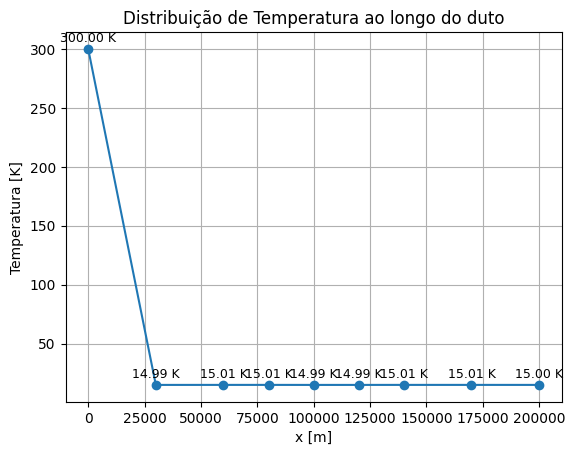

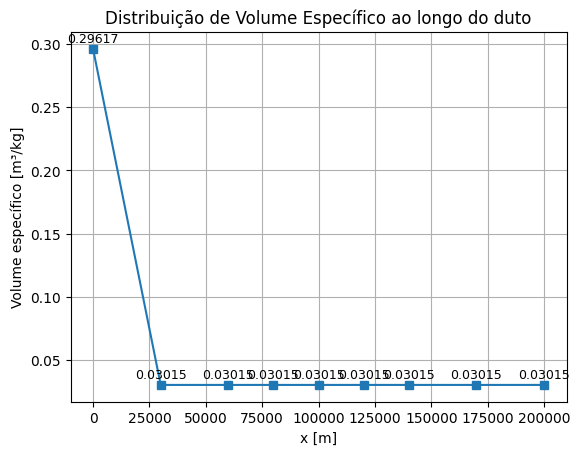

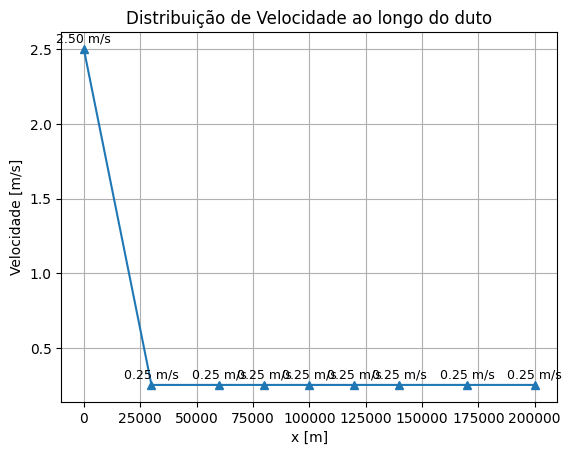

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# --- Temperatura (K) ---
plt.figure()
plt.plot(x_avaliar, T_sol, marker='o', linestyle='-')
for xi, Ti in zip(x_avaliar, T_sol):
    plt.annotate(f'{Ti:.2f} K', xy=(xi, Ti), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=9)
plt.title('Distribuição de Temperatura ao longo do duto')
plt.xlabel('x [m]')
plt.ylabel('Temperatura [K]')
plt.grid(True)

# --- Volume específico (m³/kg) ---
plt.figure()
plt.plot(x_avaliar, V_sol, marker='s', linestyle='-')
for xi, Vi in zip(x_avaliar, V_sol):
    plt.annotate(f'{Vi:.5f}', xy=(xi, Vi), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=9)
plt.title('Distribuição de Volume Específico ao longo do duto')
plt.xlabel('x [m]')
plt.ylabel('Volume específico [m³/kg]')
plt.grid(True)

# --- Velocidade (m/s) ---
plt.figure()
plt.plot(x_avaliar, w_sol, marker='^', linestyle='-')
for xi, wi in zip(x_avaliar, w_sol):
    plt.annotate(f'{wi:.2f} m/s', xy=(xi, wi), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=9)
plt.title('Distribuição de Velocidade ao longo do duto')
plt.xlabel('x [m]')
plt.ylabel('Velocidade [m/s]')
plt.grid(True)

plt.show()


In [ ]:
x0 = np.concatenate([T_sol, V_sol, w_sol])
y0 = [T_sol[-1], V_sol[1], w_sol[-1]]  # estado inicial completo
print(meu_duto.estacionario(0.0, y0))

In [ ]:
T0 = T_sol
V0 = V_sol
w0 = w0_sol

y0 = np.empty(n_nodes * 3)
y0[0::3] = T0
y0[1::3] = V0
y0[2::3] = w0

# Definir wrapper da função para solve_ivp
def dae_wrapper(t, y):
    return meu_duto.evaluate_dae(t, y)

# Intervalo de tempo de simulação
t_span = (0, 1000)  # de 0 a 10 segundos
t_eval = np.linspace(*t_span, 200)  # 200 pontos de avaliação

# Resolver a DAE
sol = solve_ivp(
    dae_wrapper,
    t_span=t_span,
    y0=y0,
    method='LSODA',  # pode testar 'BDF' se o sistema for stiff
    t_eval=t_eval
)


In [ ]:
import matplotlib.ticker as mtick

plt.figure(figsize=(10, 6))
for i in range(n_nodes):
    plt.plot(sol.t, sol.y[0::3][i], label=f'Nó {i}')
plt.xlabel('Tempo / s')
plt.ylabel('Temperatura / K')
plt.title('Evolução da Temperatura em todos os nós')
plt.legend()
plt.grid(True)

ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.ScalarFormatter())
ax.ticklabel_format(useOffset=False, style='plain')  # força números "normais"
plt.show()

plt.figure(figsize=(10, 6))
for i in range(n_nodes):
    plt.plot(sol.t, sol.y[1::3][i], label=f'Nó {i}')
plt.xlabel('Tempo / s')
plt.ylabel('V / m³/kg')
plt.legend()
plt.grid(True)

ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.ScalarFormatter())
ax.ticklabel_format(useOffset=False, style='plain')
plt.show()

plt.figure(figsize=(10, 6))
for i in range(n_nodes):
    plt.plot(sol.t, sol.y[2::3][i], label=f'Nó {i}')
plt.xlabel('Tempo / s')
plt.ylabel('Velocidade / m/s')
plt.legend()
plt.grid(True)

ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.ScalarFormatter())
ax.ticklabel_format(useOffset=False, style='plain')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

n_nodes = len(meu_duto.l)
x_nodes = meu_duto.l  # posição de cada nó ao longo do duto

# Selecionar índices do tempo inicial e final
idx_inicio = 0
idx_final = -1

# Extrair dados
T_inicio = sol.y[0::3, idx_inicio]
V_inicio = sol.y[1::3, idx_inicio]
w_inicio = sol.y[2::3, idx_inicio]

T_final = sol.y[0::3, idx_final]
V_final = sol.y[1::3, idx_final]
w_final = sol.y[2::3, idx_final]


plt.figure(figsize=(10, 5))
plt.plot(x_nodes, T_inicio, 'o-', label='Início')
plt.plot(x_nodes, T_final, 's-', label='Final')
plt.xlabel('Posição ao longo do duto / m')
plt.ylabel('Temperatura / K')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(x_nodes, V_inicio, 'o-', label='Início')
plt.plot(x_nodes, V_final, 's-', label='Final')
plt.xlabel('Posição ao longo do duto / m')
plt.ylabel('Volume específico m³/kg')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(x_nodes, w_inicio, 'o-', label='Início')
plt.plot(x_nodes, w_final, 's-', label='Final')
plt.xlabel('Posição ao longo do duto / m')
plt.ylabel('Velocidade / m/s')
plt.legend()
plt.grid(True)
plt.show()